## 1. Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Sector Stocks Data

In [3]:
# Load the sector stocks CSV
sector_df = pd.read_csv('sector_stocks.csv')

print(f"Total stocks loaded: {len(sector_df)}")
print(f"\nStocks by sector:")
print(sector_df['Sector_Code'].value_counts().sort_index())
print(f"\nFirst few rows:")
sector_df.head(10)

Total stocks loaded: 302

Stocks by sector:
Sector_Code
XLF    65
XLI    66
XLK    60
XLV    63
XLY    48
Name: count, dtype: int64

First few rows:


,Symbol,Sector,Sector_Code
0,AAPL,Technology,XLK
1,MSFT,Technology,XLK
2,NVDA,Technology,XLK
3,AVGO,Technology,XLK
4,CRM,Technology,XLK
5,ORCL,Technology,XLK
6,CSCO,Technology,XLK
7,ACN,Technology,XLK
8,AMD,Technology,XLK
9,ADBE,Technology,XLK


## 3. Data Overview and Summary Statistics

In [15]:
# Display basic information
print("Dataset Shape:", sector_df.shape)
print("\nColumn Names:")
print(sector_df.columns.tolist())
print("\nData Types:")
print(sector_df.dtypes)
print("\nMissing Values:")
print(sector_df.isnull().sum())
print("\nUnique Sectors:")
print(sector_df['Sector'].unique())

Dataset Shape: (302, 3)

Column Names:
['Symbol', 'Sector', 'Sector_Code']

Data Types:
Symbol         object
Sector         object
Sector_Code    object
dtype: object

Missing Values:
Symbol         0
Sector         0
Sector_Code    0
dtype: int64

Unique Sectors:
['Technology' 'Healthcare' 'Financial' 'Industrial'
 'Consumer Discretionary']


## 4. Visualize Sector Distribution

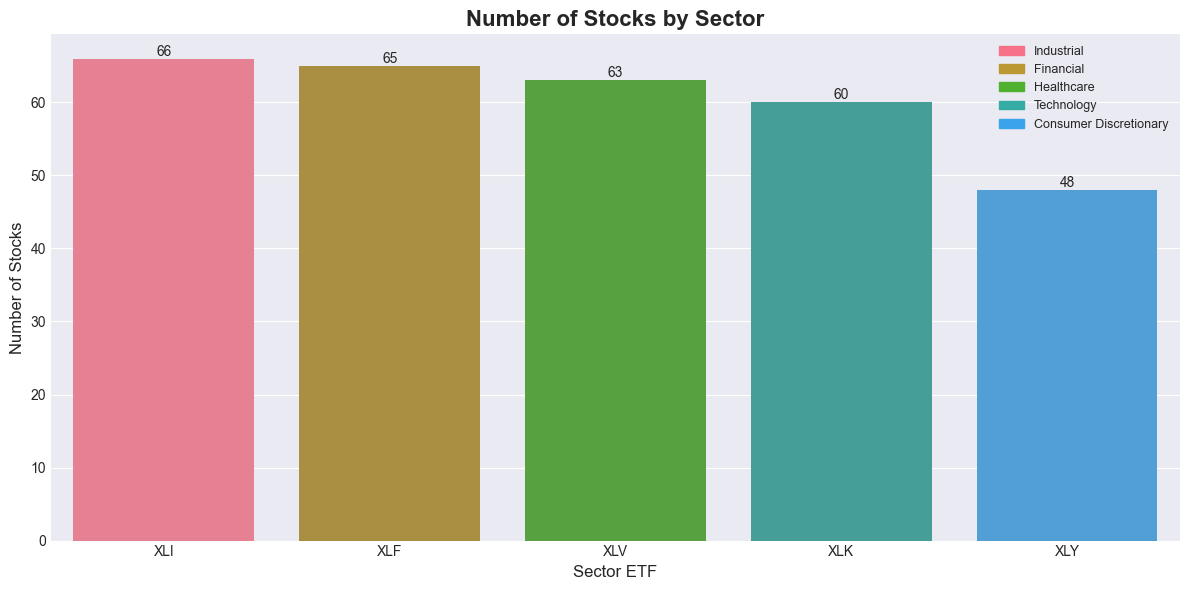


Sector Distribution:
  Sector_Code                  Sector  Count
1         XLI              Industrial     66
0         XLF               Financial     65
3         XLV              Healthcare     63
2         XLK              Technology     60
4         XLY  Consumer Discretionary     48


In [16]:
# Create a bar plot of stocks per sector
plt.figure(figsize=(12, 6))
sector_counts = sector_df.groupby(['Sector_Code', 'Sector']).size().reset_index(name='Count')
sector_counts = sector_counts.sort_values('Count', ascending=False)

ax = sns.barplot(data=sector_counts, x='Sector_Code', y='Count', hue='Sector', dodge=False, legend=False)
plt.title('Number of Stocks by Sector', fontsize=16, fontweight='bold')
plt.xlabel('Sector ETF', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

# Add legend with full sector names
handles = [plt.Rectangle((0,0),1,1, color=sns.color_palette('husl')[i]) for i in range(len(sector_counts))]
plt.legend(handles, sector_counts['Sector'].tolist(), loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

print("\nSector Distribution:")
print(sector_counts)

## 5. Select Stocks for Analysis
Choose whether to analyze all stocks or just top 3 from each sector.

**Note**: The following 5 stocks failed to download from Yahoo Finance and hence were  excluded from analysis - some I know are already acquired by other companies:
- DFS (Financial)
- JNPR (Technology)
- TPX (Consumer Discretionary)
- ANSS (Technology)
- CTLT (Healthcare)

In [4]:
# Configuration: Set to True to use all stocks, False to use top 3 per sector
USE_ALL_STOCKS = True  # Change to True to analyze all stocks

# Get all stocks for downloading
all_stocks = sector_df['Symbol'].tolist()

# Select stocks for analysis based on configuration
if USE_ALL_STOCKS:
    analysis_stocks = all_stocks
    print(f"Using ALL {len(analysis_stocks)} stocks for analysis")
else:
    # Select top 3 from each sector for quick analysis
    analysis_stocks = []
    for sector_code in sector_df['Sector_Code'].unique():
        sector_stocks = sector_df[sector_df['Sector_Code'] == sector_code]['Symbol'].head(3).tolist()
        analysis_stocks.extend(sector_stocks)
    print(f"Using top 3 stocks per sector ({len(analysis_stocks)} total) for quick analysis")
    print("\nTo analyze all stocks, set USE_ALL_STOCKS = True and re-run this cell.")

print(f"\nSelected stocks by sector:")
for sector_code in sector_df['Sector_Code'].unique():
    sector_samples = [s for s in analysis_stocks if s in sector_df[sector_df['Sector_Code'] == sector_code]['Symbol'].values]
    sector_name = sector_df[sector_df['Sector_Code'] == sector_code]['Sector'].iloc[0]
    print(f"\n{sector_code} ({sector_name}): {len(sector_samples)} stocks")
    if not USE_ALL_STOCKS:
        print(f"  {', '.join(sector_samples)}")

Using ALL 302 stocks for analysis

Selected stocks by sector:

XLK (Technology): 61 stocks

XLV (Healthcare): 63 stocks

XLF (Financial): 65 stocks

XLI (Industrial): 67 stocks

XLY (Consumer Discretionary): 48 stocks


## 6. Download Historical Price Data
Download data for ALL stocks and cache it, then filter for analysis.

In [6]:
# Define date range for historical data (last 2 years)
end_date = datetime.now()
start_date = end_date - timedelta(days=730)  # 2 years

# Define local cache file for ALL stocks data
cache_file_all = 'price_data_all_stocks_cache.pkl'

import os

# Define cache validity period (e.g., 1 week = 7 days)
CACHE_VALIDITY_DAYS = 7

# Step 1: Download/load data for ALL stocks
cache_is_valid = False

if os.path.exists(cache_file_all):
    print(f"Found cached data file '{cache_file_all}'. Checking freshness...")
    all_price_data = pd.read_pickle(cache_file_all)
    
    # Check the last date in the cache
    cache_end_date = all_price_data.index[-1]
    days_old = (end_date - cache_end_date).days
    
    print(f"Cached data ends on: {cache_end_date.strftime('%Y-%m-%d')}")
    print(f"Cache is {days_old} days old")
    
    if days_old <= CACHE_VALIDITY_DAYS:
        cache_is_valid = True
        print(f" Cache is fresh (less than {CACHE_VALIDITY_DAYS} days old). Using cached data.")
        print(f"Data date range: {all_price_data.index[0]} to {all_price_data.index[-1]}")
        print(f"Total stocks in cache: {len(all_price_data.columns.get_level_values(1).unique())}")
        print(f"Shape: {all_price_data.shape}")
    else:
        print(f" Cache is stale (more than {CACHE_VALIDITY_DAYS} days old). Will re-download data.")

if not cache_is_valid:
    print(f"\nDownloading fresh data for ALL {len(all_stocks)} stocks...")
    print(f"Date range: {start_date.date()} to {end_date.date()}")
    print("This will take several minutes...\n")
    
    # Download data for ALL stocks
    all_price_data = yf.download(all_stocks, start=start_date, end=end_date, progress=True)
    
    # Save to cache
    all_price_data.to_pickle(cache_file_all)
    print(f"\n Data downloaded and saved to '{cache_file_all}'")
    print(f"Shape: {all_price_data.shape}")

# Step 2: Filter data for analysis based on selected stocks
print(f"\n{'='*60}")
if USE_ALL_STOCKS:
    price_data = all_price_data
    print(f"Using ALL stocks for analysis: {len(analysis_stocks)} stocks")
else:
    # Filter to only analysis_stocks
    if isinstance(all_price_data.columns, pd.MultiIndex):
        # Get the level that contains stock symbols
        symbol_level = 1 if all_price_data.columns.names[1] == 'Ticker' else 0
        price_data = all_price_data.loc[:, all_price_data.columns.get_level_values(symbol_level).isin(analysis_stocks)]
    else:
        price_data = all_price_data[analysis_stocks]
    print(f"Filtered to {len(analysis_stocks)} stocks for analysis")

print(f"Analysis dataset shape: {price_data.shape}")
print(f"{'='*60}")

price_data.head()

Found cached data file 'price_data_all_stocks_cache.pkl'. Checking freshness...
Cached data ends on: 2026-01-09
Cache is 2 days old
 Cache is fresh (less than 7 days old). Using cached data.
Data date range: 2024-01-12 00:00:00 to 2026-01-09 00:00:00
Total stocks in cache: 301
Shape: (500, 1505)

Using ALL stocks for analysis: 302 stocks
Analysis dataset shape: (500, 1505)


Price            Close                                                  \
Ticker               A        AAPL        ABBV        ABNB         ABT   
Date                                                                     
2024-01-12  128.605194  184.180603  152.826035  137.139999  110.143608   
2024-01-16  128.595337  181.912033  151.960281  135.020004  109.988922   
2024-01-17  126.221062  180.970917  152.487259  134.979996  110.153282   
2024-01-18  128.526382  186.865234  153.672974  137.039993  110.240303   
2024-01-19  129.275146  189.767838  155.056320  139.929993  110.888084   

Price                                                                  ...  \
Ticker           ACGL         ACN        ADBE         ADI         ADP  ...   
Date                                                                   ...   
2024-01-12  73.875305  345.756042  596.539978  182.213074  225.874664  ...   
2024-01-16  74.331734  344.038574  597.679993  181.661682  225.233261  ...   
2024-01-17  74.807182  344.408630  596.099976  179.378693  225.338562  ...   
2024-01-18  75.082947  350.154449  593.700012  183.770554  225.999069  ...   
2024-01-19  76.908669  354.390808  611.549988  188.413910  228.066879  ...   

Price        Volume                                                      \
Ticker          WHR       WM      WRB     WST     WTW     XRAY      XYL   
Date                                                                      
2024-01-12  1603000  1035700  1605600  351400  354200  1937200  1233100   
2024-01-16  1547500  1456100  1426950  381700  432100  2087100  1561500   
2024-01-17   712600  1751500  1255350  228900  414000  1412900  1353100   
2024-01-18   708200  1732100   908700  314800  263600  1517000  1276500   
2024-01-19   697600  1571600  2227050  385800  597700  1942100  1129300   

Price                                 
Ticker          YUM    ZBRA      ZTS  
Date                                  
2024-01-12  1081800  625600  1726500  
2024-01-16  1635900  498300  2316200  
2024-01-17  1314900  463200  1678000  
2024-01-18  1896500  482200  3832800  
2024-01-19  1927800  397600  2285100  

[5 rows x 1505 columns]

## 7. Calculate Basic Returns

In [8]:
# Check the structure of price_data
print("Price data shape:", price_data.shape)
print("Column levels:", price_data.columns.nlevels)
print("\nFirst 5 columns:")
print(price_data.columns[:5].tolist())

# Check for stocks with all NaN values and remove them
if isinstance(price_data.columns, pd.MultiIndex):
    # For MultiIndex, check at the ticker level
    ticker_level = 1 if 'Ticker' in price_data.columns.names else 0
    tickers = price_data.columns.get_level_values(ticker_level).unique()
    
    # Find tickers with all NaN values
    stocks_to_remove = []
    for ticker in tickers:
        ticker_data = price_data.xs(ticker, level=ticker_level, axis=1)
        if ticker_data.isna().all().all():
            stocks_to_remove.append(ticker)
    
    if stocks_to_remove:
        print(f"\n Removing {len(stocks_to_remove)} stocks with no data: {stocks_to_remove}")
        # Remove stocks with all NaN
        valid_tickers = [t for t in tickers if t not in stocks_to_remove]
        price_data = price_data.loc[:, price_data.columns.get_level_values(ticker_level).isin(valid_tickers)]
        print(f" Cleaned data shape: {price_data.shape}")
    else:
        print("\n No stocks with missing data found")
else:
    # Single stock - check if all NaN
    if price_data.isna().all().all():
        print(" Warning: All data is NaN!")
    else:
        print("\n Data looks good")

print(f"\nFinal analysis will use {len(price_data.columns.get_level_values(1).unique()) if isinstance(price_data.columns, pd.MultiIndex) else 1} stocks")

# Handle both single and multi-stock data structures
if isinstance(price_data.columns, pd.MultiIndex):
    # Multi-stock data: columns are MultiIndex (ticker, metric) or (metric, ticker)
    # Check which level has 'Adj Close'
    if 'Adj Close' in price_data.columns.get_level_values(0):
        # Format: (metric, ticker)
        returns = price_data.xs('Adj Close', level=0, axis=1).pct_change()
    elif 'Adj Close' in price_data.columns.get_level_values(1):
        # Format: (ticker, metric)
        returns = price_data.xs('Adj Close', level=1, axis=1).pct_change()
    else:
        # Fallback to Close
        print("Warning: 'Adj Close' not found, using 'Close'")
        returns = price_data.xs('Close', level=0, axis=1).pct_change()
else:
    # Single stock data: check if 'Adj Close' exists
    if 'Adj Close' in price_data.columns:
        returns = price_data['Adj Close'].pct_change()
    else:
        # Use Close if Adj Close not available
        returns = price_data['Close'].pct_change()

# Calculate cumulative returns
cumulative_returns = (1 + returns).cumprod() - 1

print("\nReturns shape:", returns.shape)
print("\nDaily Returns Statistics:")
print(returns.describe())

Price data shape: (500, 1505)
Column levels: 2

First 5 columns:
[('Close', 'A'), ('Close', 'AAPL'), ('Close', 'ABBV'), ('Close', 'ABNB'), ('Close', 'ABT')]

 No stocks with missing data found

Final analysis will use 301 stocks

Returns shape: (500, 301)

Daily Returns Statistics:
Ticker           A        AAPL        ABBV        ABNB         ABT  \
count   499.000000  499.000000  499.000000  499.000000  499.000000   
mean      0.000454    0.000839    0.000860    0.000281    0.000349   
std       0.018190    0.017597    0.015965    0.022383    0.012699   
min      -0.096646   -0.092456   -0.125664   -0.133824   -0.085244   
25%      -0.009742   -0.006865   -0.006406   -0.010300   -0.006225   
50%       0.000346    0.001187    0.000622    0.001081    0.000286   
75%       0.010402    0.008357    0.009474    0.011753    0.007147   
max       0.080613    0.153288    0.063605    0.147885    0.046188   

Ticker        ACGL         ACN        ADBE         ADI         ADP  ...  \
count   499

## 8. Visualize Stock Price Trends by Sector

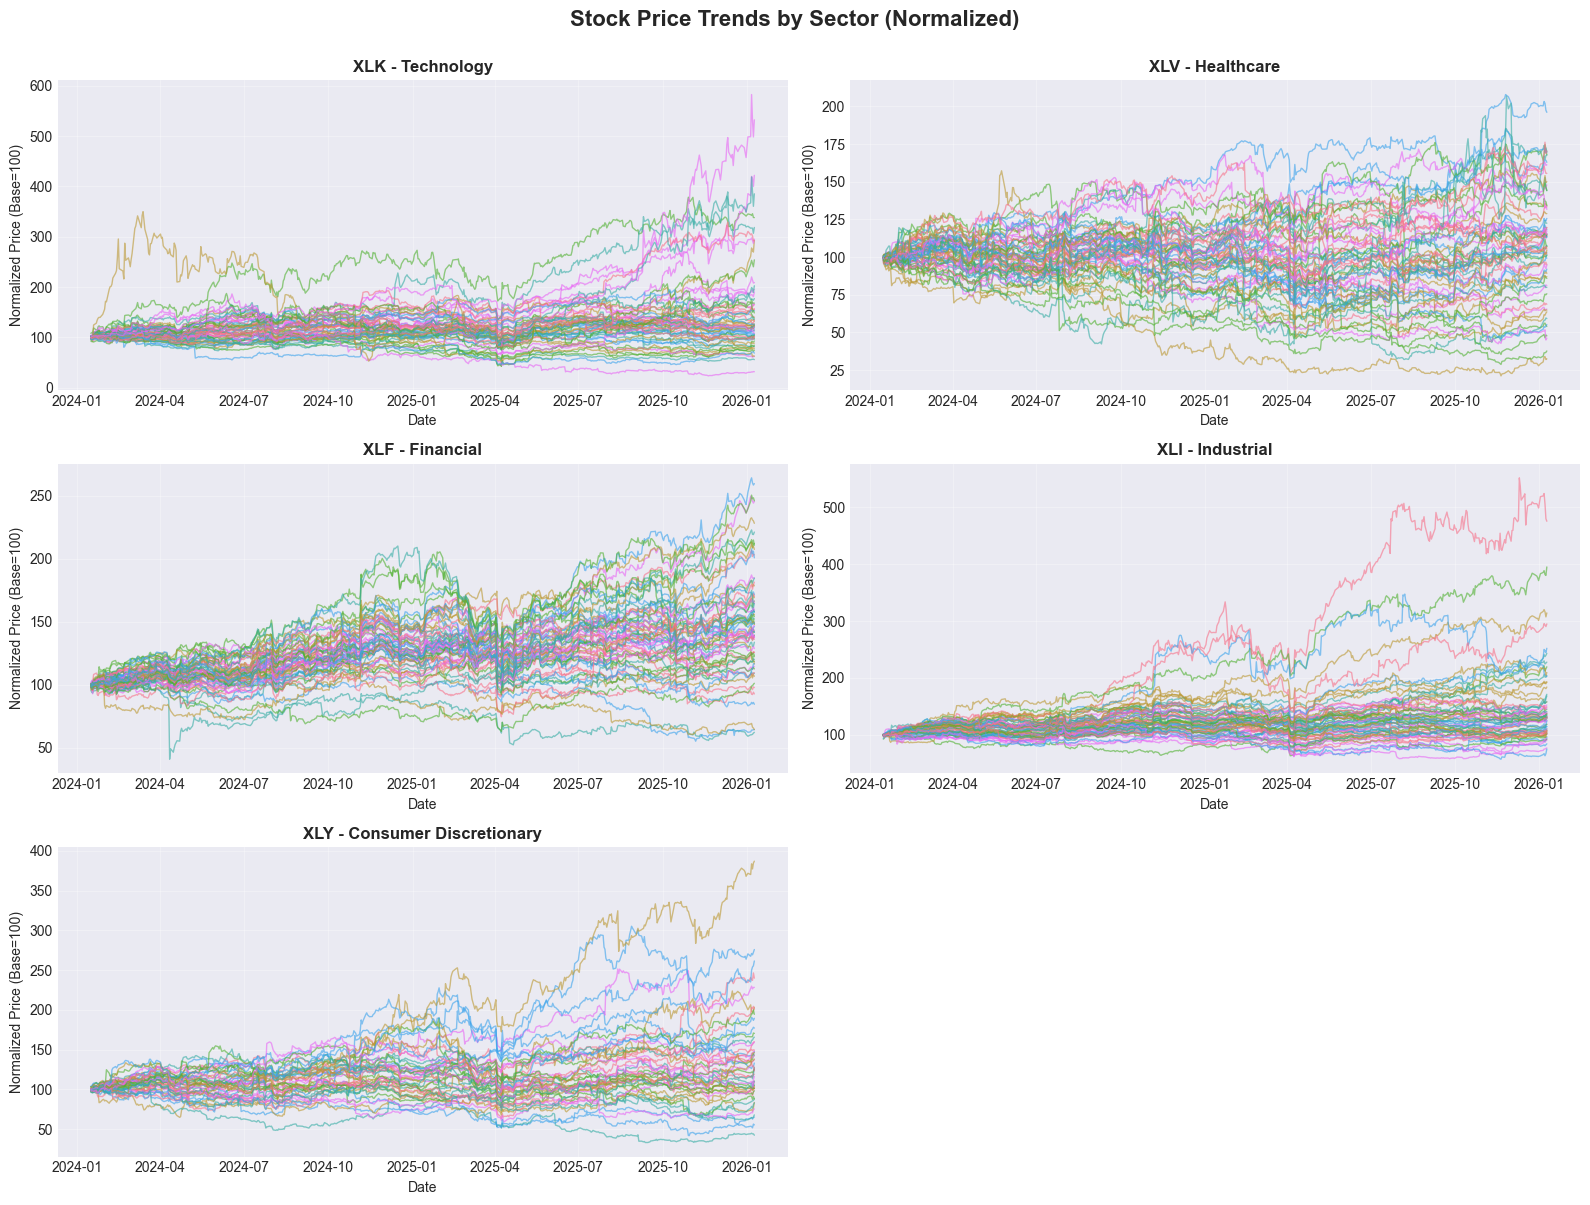

In [9]:
# Create subplots for each sector
sectors = sector_df['Sector_Code'].unique()
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, sector_code in enumerate(sectors):
    sector_name = sector_df[sector_df['Sector_Code'] == sector_code]['Sector'].iloc[0]
    sector_stocks = [s for s in analysis_stocks if s in sector_df[sector_df['Sector_Code'] == sector_code]['Symbol'].values]
    
    ax = axes[idx]
    
    # Plot normalized prices (starting at 100)
    for stock in sector_stocks:
        if stock in cumulative_returns.columns:
            normalized_price = (1 + cumulative_returns[stock]) * 100
            if USE_ALL_STOCKS:
                # Don't show legend for all stocks (too crowded)
                ax.plot(normalized_price.index, normalized_price.values, linewidth=1, alpha=0.6)
            else:
                ax.plot(normalized_price.index, normalized_price.values, label=stock, linewidth=2)
    
    ax.set_title(f'{sector_code} - {sector_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Normalized Price (Base=100)', fontsize=10)
    if not USE_ALL_STOCKS:
        ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide extra subplot if odd number of sectors
if len(sectors) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Stock Price Trends by Sector (Normalized)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 9. Correlation Analysis

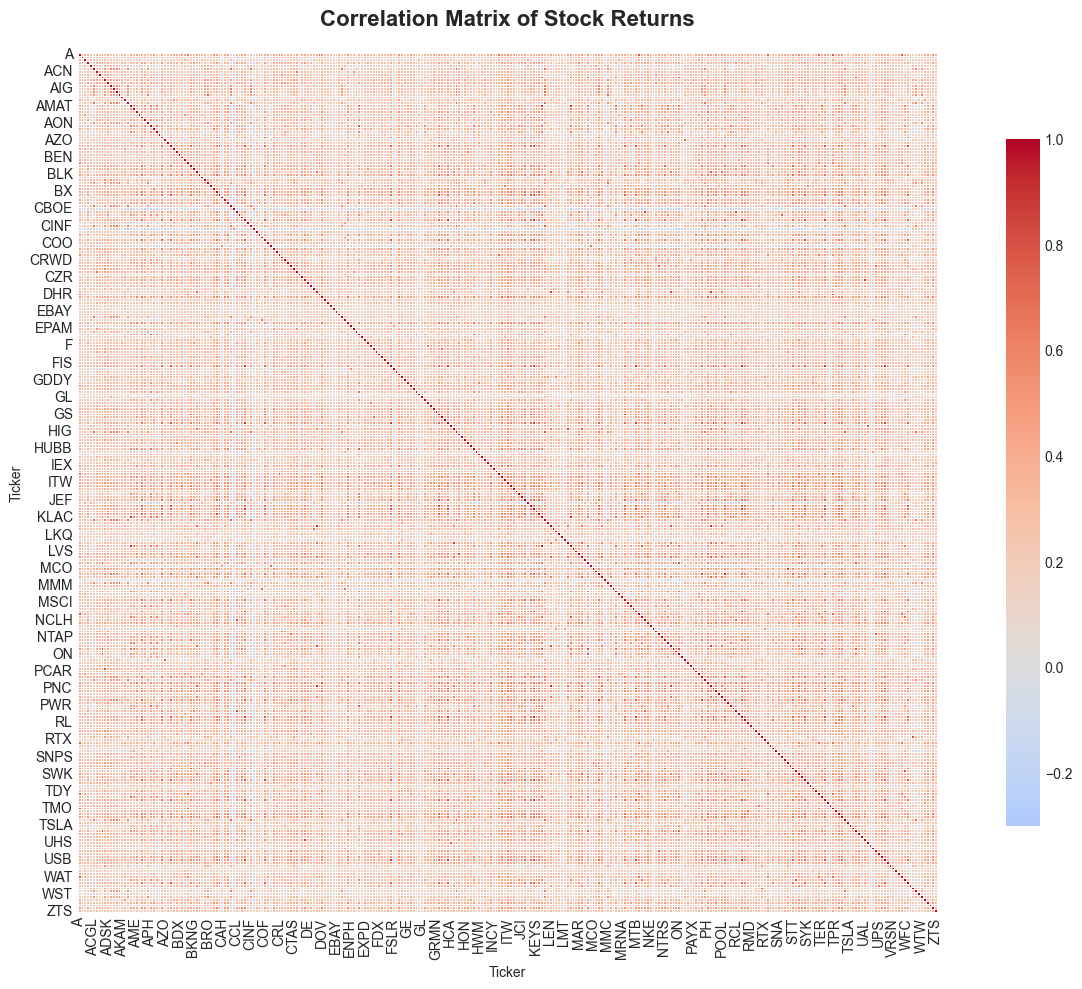


Highest Correlations (excluding self):
Ticker  Ticker
LEN     PHM       0.912808
PHM     LEN       0.912808
KLAC    LRCX      0.912747
LRCX    KLAC      0.912747
AMAT    KLAC      0.911082
KLAC    AMAT      0.911082
PHM     DHI       0.910870
DHI     PHM       0.910870
AMAT    LRCX      0.902786
LRCX    AMAT      0.902786
dtype: float64


In [10]:
# Calculate correlation matrix of returns
correlation_matrix = returns.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Stock Returns', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nHighest Correlations (excluding self):")
# Get top correlations
corr_pairs = correlation_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs < 1.0]  # Exclude self-correlation
print(corr_pairs.sort_values(ascending=False).head(10))

## 10. Volatility Analysis

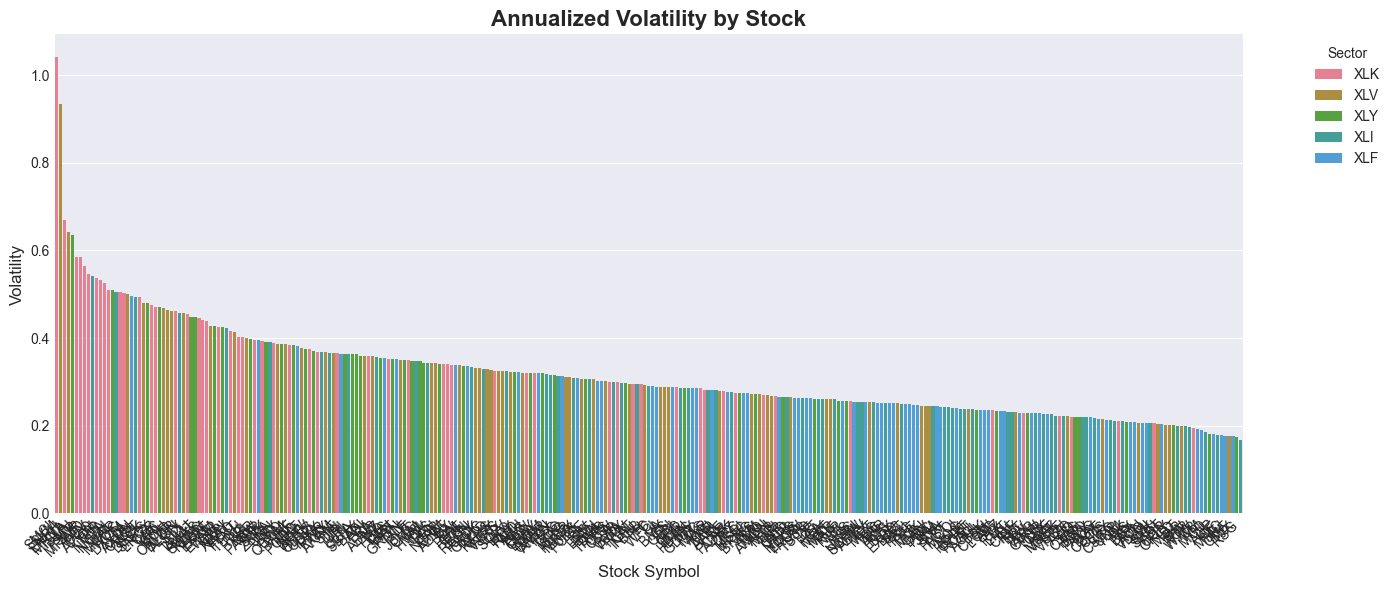


Top 10 Most Volatile Stocks:
    Symbol  Volatility                  Sector Sector_Code
245   SMCI    1.040658              Technology         XLK
257    SYM    0.934538              Healthcare         XLV
96    ENPH    0.670076              Technology         XLK
191   MRNA    0.642293              Healthcare         XLV
271   TSLA    0.635883  Consumer Discretionary         XLY
198     MU    0.585601              Technology         XLK
111   FSLR    0.584018              Technology         XLK
189   MPWR    0.564765              Technology         XLK
19     AMD    0.545826              Technology         XLK
119    GEV    0.540544              Industrial         XLI

Average Volatility by Sector:
Sector_Code
XLK    0.389733
XLY    0.334130
XLV    0.328957
XLI    0.281530
XLF    0.263290
Name: Volatility, dtype: float64


In [11]:
# Calculate annualized volatility
volatility = returns.std() * np.sqrt(252)  # 252 trading days

# Create dataframe with volatility
volatility_df = pd.DataFrame({
    'Symbol': volatility.index,
    'Volatility': volatility.values
})

# Add sector information
volatility_df = volatility_df.merge(sector_df[['Symbol', 'Sector', 'Sector_Code']], on='Symbol', how='left')
volatility_df = volatility_df.sort_values('Volatility', ascending=False)

# Plot volatility by sector
plt.figure(figsize=(14, 6))
sns.barplot(data=volatility_df, x='Symbol', y='Volatility', hue='Sector_Code', dodge=False)
plt.title('Annualized Volatility by Stock', fontsize=16, fontweight='bold')
plt.xlabel('Stock Symbol', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Volatile Stocks:")
print(volatility_df.head(10))

print("\nAverage Volatility by Sector:")
print(volatility_df.groupby('Sector_Code')['Volatility'].mean().sort_values(ascending=False))

## 11. Risk-Return Analysis

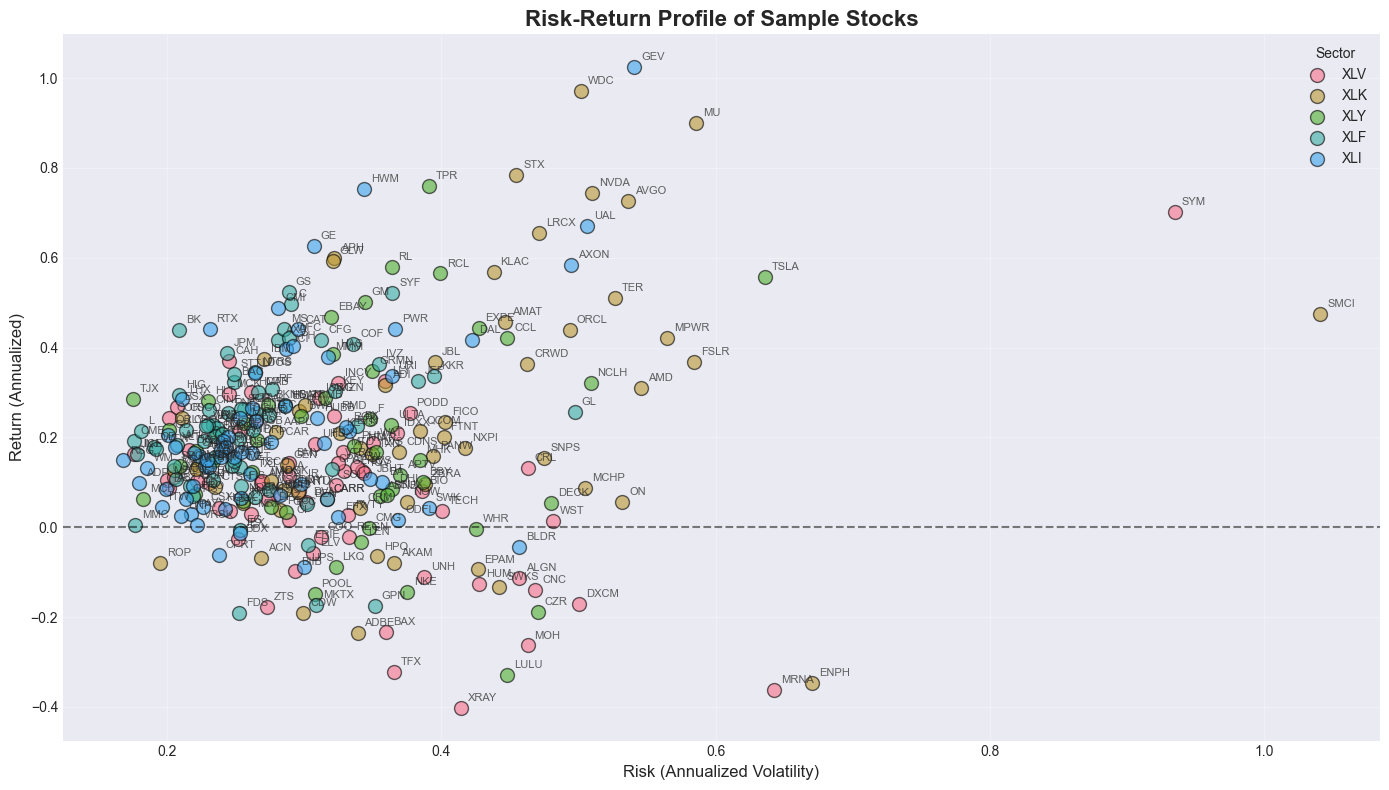


Risk-Return Summary:
    Symbol    Return      Risk                  Sector Sector_Code
119    GEV  1.025504  0.540544              Industrial         XLI
290    WDC  0.970946  0.501804              Technology         XLK
198     MU  0.899308  0.585601              Technology         XLK
252    STX  0.784216  0.454539              Technology         XLK
266    TPR  0.760551  0.390915  Consumer Discretionary         XLY
..     ...       ...       ...                     ...         ...
263    TFX -0.321126  0.365419              Healthcare         XLV
174   LULU -0.328524  0.447806  Consumer Discretionary         XLY
96    ENPH -0.346448  0.670076              Technology         XLK
191   MRNA -0.361519  0.642293              Healthcare         XLV
297   XRAY -0.403153  0.414167              Healthcare         XLV

[302 rows x 5 columns]


In [12]:
# Calculate annualized returns
annual_returns = returns.mean() * 252

# Create risk-return dataframe
risk_return_df = pd.DataFrame({
    'Symbol': annual_returns.index,
    'Return': annual_returns.values,
    'Risk': volatility.values
})

# Add sector information
risk_return_df = risk_return_df.merge(sector_df[['Symbol', 'Sector', 'Sector_Code']], on='Symbol', how='left')

# Plot risk-return scatter
plt.figure(figsize=(14, 8))
for sector_code in risk_return_df['Sector_Code'].unique():
    sector_data = risk_return_df[risk_return_df['Sector_Code'] == sector_code]
    plt.scatter(sector_data['Risk'], sector_data['Return'], 
               label=sector_code, s=100, alpha=0.6, edgecolors='black', linewidth=1)
    
    # Add labels for each point
    for idx, row in sector_data.iterrows():
        plt.annotate(row['Symbol'], (row['Risk'], row['Return']), 
                    fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')

plt.title('Risk-Return Profile of Sample Stocks', fontsize=16, fontweight='bold')
plt.xlabel('Risk (Annualized Volatility)', fontsize=12)
plt.ylabel('Return (Annualized)', fontsize=12)
plt.legend(title='Sector', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\nRisk-Return Summary:")
print(risk_return_df.sort_values('Return', ascending=False))

## 12. Performance Metrics Summary

In [13]:
# Calculate Sharpe Ratio (assuming risk-free rate = 0.04 or 4%)
risk_free_rate = 0.04
sharpe_ratio = (annual_returns - risk_free_rate) / volatility

# Create summary dataframe
performance_summary = pd.DataFrame({
    'Symbol': annual_returns.index,
    'Annual_Return': annual_returns.values,
    'Volatility': volatility.values,
    'Sharpe_Ratio': sharpe_ratio.values,
    'Total_Return': cumulative_returns.iloc[-1].values
})

# Add sector information
performance_summary = performance_summary.merge(sector_df[['Symbol', 'Sector', 'Sector_Code']], 
                                                on='Symbol', how='left')

# Sort by Sharpe Ratio
performance_summary = performance_summary.sort_values('Sharpe_Ratio', ascending=False)

print("\nPerformance Summary (Top 10 by Sharpe Ratio):")
print(performance_summary.head(10))

print("\n\nPerformance by Sector:")
sector_performance = performance_summary.groupby('Sector_Code').agg({
    'Annual_Return': 'mean',
    'Volatility': 'mean',
    'Sharpe_Ratio': 'mean',
    'Total_Return': 'mean'
}).round(4)
print(sector_performance.sort_values('Sharpe_Ratio', ascending=False))


Performance Summary (Top 10 by Sharpe Ratio):
    Symbol  Annual_Return  Volatility  Sharpe_Ratio  Total_Return  \
141    HWM       0.752841    0.343577      2.074764      2.952448   
39      BK       0.438942    0.208855      1.910140      1.282856   
116     GE       0.626070    0.306908      1.909598      2.142941   
290    WDC       0.970946    0.501804      1.855199      4.323454   
266    TPR       0.760551    0.390915      1.843242      2.869429   
119    GEV       1.025504    0.540544      1.823170      3.757591   
241    RTX       0.442475    0.230962      1.742602      1.276415   
25     APH       0.599184    0.321327      1.740233      1.951949   
122    GLW       0.593043    0.320542      1.725335      1.921611   
127     GS       0.523810    0.288504      1.676962      1.597890   

                     Sector Sector_Code  
141              Industrial         XLI  
39                Financial         XLF  
116              Industrial         XLI  
290              Technolo

## 14. Save Results

In [14]:
# Save performance summary
performance_summary.to_csv('stock_performance_summary.csv', index=False)
print("Performance summary saved to 'stock_performance_summary.csv'")

# Save sector performance
sector_performance.to_csv('sector_performance_summary.csv')
print("Sector performance saved to 'sector_performance_summary.csv'")

print("\nAnalysis complete!")

Performance summary saved to 'stock_performance_summary.csv'
Sector performance saved to 'sector_performance_summary.csv'

Analysis complete!
